# Notebook 1: SVM con Margen Duro

### Introducción

El SVM con margen duro es un algoritmo de clasificación para datos linealmente separables. El objetivo es encontrar el hiperplano que maximiza el margen entre dos clases.

### Importación de Librerías

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

### Generación de datos sintéticos

In [3]:
# Generar datos linealmente separables
np.random.seed(42)
N = 50
X_pos = np.random.randn(N, 2) + [2, 2]
X_neg = np.random.randn(N, 2) + [-2, -2]
X = np.vstack((X_pos, X_neg))
y = np.hstack((np.ones(N), -np.ones(N)))

### División de datos en entrenamiento y prueba

In [4]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Visualización de los Datos

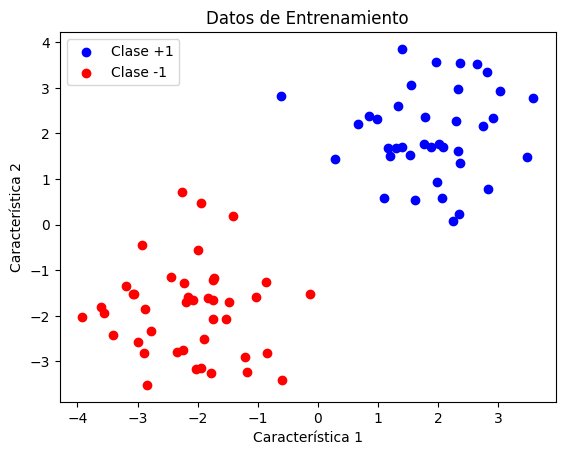

In [5]:
plt.scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1], color='b', label='Clase +1')
plt.scatter(X_train[y_train==-1][:, 0], X_train[y_train==-1][:, 1], color='r', label='Clase -1')
plt.legend()
plt.title('Datos de Entrenamiento')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()

## Implementación del SVM con Margen Duro

### Formulación del problema

Queremos resolver el siguiente problema de optimización:

\begin{equation}
\min_{w, b} \frac{1}{2}||w||^2
\end{equation}

Sujeto a las restricciones:

\begin{equation}
y_i(w^Tx_i + b) \geq 1, \forall i
\end{equation}

### Resolución con Multiplicadores de Lagrange

Implementaremos la solución dual utilizando matrices de numpy.

In [6]:
# Construir la matriz de Gram
def compute_gram_matrix(X, y):
    m = X.shape[0]
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = y[i] * y[j] * np.dot(X[i], X[j])
    return K

### Resolución del Problema Dual

Usaremos un solucionador de programación cuadrática. Sin embargo, dado que no podemos usar librerías externas, implementaremos un método simplificado.

In [7]:
# Implementación del SVM con margen duro
def fit_svm_hard(X, y):
    m, n = X.shape
    K = compute_gram_matrix(X, y)
    P = K
    q = -np.ones(m)
    # Aplicamos restricciones de α_i ≥ 0
    alpha = np.zeros(m)
    # Iteración simple (esto es una simplificación y no garantiza convergencia)
    for _ in range(1000):
        gradient = np.dot(P, alpha) + q
        alpha -= 0.001 * gradient  # Paso de aprendizaje fijo
        alpha = np.maximum(alpha, 0)
    # Calculamos w y b
    w = np.sum((alpha * y)[:, None] * X, axis=0)
    idx = np.where(alpha > 1e-5)[0]
    if len(idx) == 0:
        print("No se encontraron vectores de soporte. El problema puede no ser linealmente separable.")
        b = 0
    else:
        b = np.mean(y[idx] - np.dot(X[idx], w))
    # Identificar vectores de soporte
    support_vectors_idx = idx
    return w, b, alpha, support_vectors_idx

# Función para predecir
def predict(X, w, b):
    return np.sign(np.dot(X, w) + b)


## Entrenamiento del Modelo

In [8]:
w, b, alpha, support_vectors_idx = fit_svm_hard(X_train, y_train)
print("Vector de pesos w:", w)
print("Intercepto b:", b)

Vector de pesos w: [0.65735529 0.53213617]
Intercepto b: -0.029808923645430196


## Evaluación del Modelo

In [9]:
# Predicciones en el conjunto de entrenamiento
y_pred_train = predict(X_train, w, b)
print("Reporte de clasificación en el conjunto de entrenamiento:")
print(classification_report(y_train, y_pred_train))

# Predicciones en el conjunto de prueba
y_pred_test = predict(X_test, w, b)
print("Reporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred_test))

Reporte de clasificación en el conjunto de entrenamiento:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        42
         1.0       1.00      1.00      1.00        38

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00         8
         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



## Visualización del Hiperplano

In [10]:
# Función para dibujar el hiperplano y vectores de soporte
def plot_hyperplane_with_support_vectors(X, y, w, b, support_vectors_idx):
    plt.figure(figsize=(10,6))
    # Dibujar los puntos de datos
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
    # Destacar los vectores de soporte
    if len(support_vectors_idx) > 0:
        plt.scatter(X[support_vectors_idx, 0], X[support_vectors_idx, 1], s=100, facecolors='none', edgecolors='k', label='Vectores de Soporte')
    # Crear una malla para dibujar los hiperplanos
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_min, x_max = xlim
    xx = np.linspace(x_min, x_max, 100)
    # Calcular las líneas de los hiperplanos
    if w[1] != 0:
        yy = -(w[0] * xx + b) / w[1]
        margin = 1 / np.linalg.norm(w)
        yy_down = yy - np.sqrt(1 + (w[0]/w[1])**2) * margin
        yy_up = yy + np.sqrt(1 + (w[0]/w[1])**2) * margin
        # Dibujar los hiperplanos
        plt.plot(xx, yy, 'k-', label='Hiperplano de Decisión')
        plt.plot(xx, yy_down, 'k--', label='Margen')
        plt.plot(xx, yy_up, 'k--')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(loc='upper left')
    plt.title('SVM con Margen Duro y Vectores de Soporte')
    plt.show()

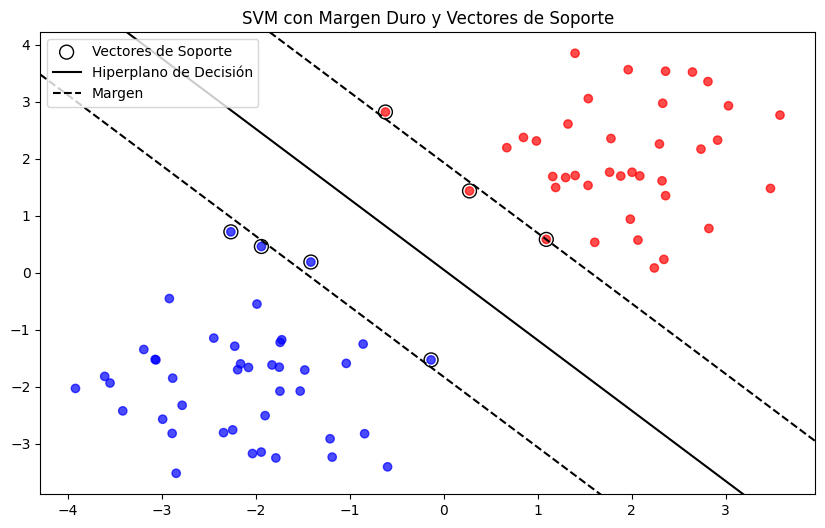

In [11]:
plot_hyperplane_with_support_vectors(X_train, y_train, w, b, support_vectors_idx)

## Agregar un Outlier Mal Clasificado

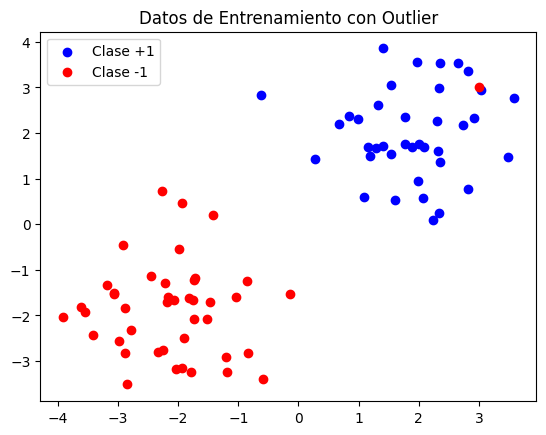

In [12]:
# Agregar un outlier a los datos de entrenamiento
outlier = np.array([[3, 3]])  # Punto en la región de la clase positiva
X_train_outlier = np.vstack([X_train, outlier])
y_train_outlier = np.hstack([y_train, [-1]])  # Etiqueta negativa

# Visualizar los datos con el outlier
plt.scatter(X_train_outlier[y_train_outlier==1][:, 0], X_train_outlier[y_train_outlier==1][:, 1], color='b', label='Clase +1')
plt.scatter(X_train_outlier[y_train_outlier==-1][:, 0], X_train_outlier[y_train_outlier==-1][:, 1], color='r', label='Clase -1')
plt.legend()
plt.title('Datos de Entrenamiento con Outlier')
plt.show()

### Entrenamiento

In [13]:
w_outlier, b_outlier, alpha_outlier, support_vectors_idx_outlier = fit_svm_hard(X_train_outlier, y_train_outlier)
print("Vector de pesos w con outlier:", w_outlier)
print("Intercepto b con outlier:", b_outlier)

Vector de pesos w con outlier: [0.34444386 0.22686497]
Intercepto b con outlier: -0.06394745953079507


### Evaluación

In [14]:
# Predicciones en el conjunto de entrenamiento
y_pred_train_outlier = predict(X_train_outlier, w_outlier, b_outlier)
print("Reporte de clasificación en el conjunto de entrenamiento con outlier:")
print(classification_report(y_train_outlier, y_pred_train_outlier))

# Predicciones en el conjunto de prueba
y_pred_test_outlier = predict(X_test, w_outlier, b_outlier)
print("Reporte de clasificación en el conjunto de prueba con outlier:")
print(classification_report(y_test, y_pred_test_outlier))

Reporte de clasificación en el conjunto de entrenamiento con outlier:
              precision    recall  f1-score   support

        -1.0       1.00      0.98      0.99        43
         1.0       0.97      1.00      0.99        38

    accuracy                           0.99        81
   macro avg       0.99      0.99      0.99        81
weighted avg       0.99      0.99      0.99        81

Reporte de clasificación en el conjunto de prueba con outlier:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00         8
         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Visualización

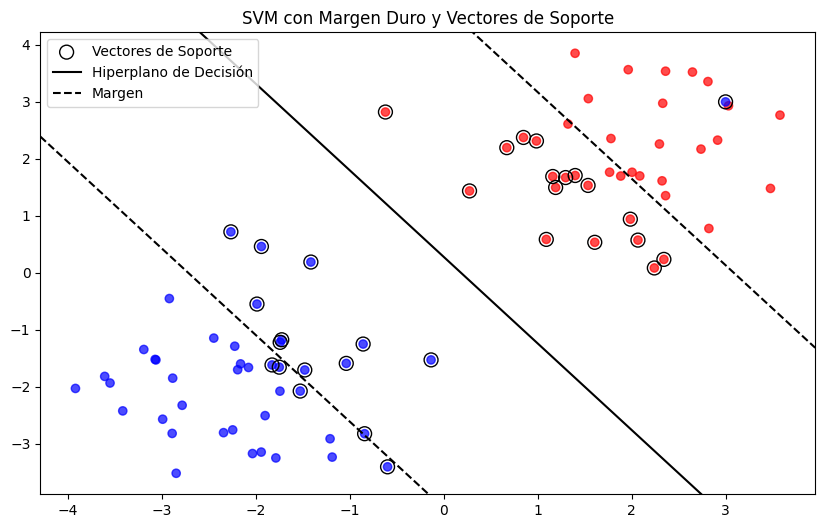

In [15]:
plot_hyperplane_with_support_vectors(X_train_outlier, y_train_outlier, w_outlier, b_outlier, support_vectors_idx_outlier)